# Carbon Assessment of Business Travels (Data Insights)

In [1]:
import pathlib
import pandas as pd
import geopandas as gpd
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings.simplefilter("ignore")

## Forewords

### Disclaimer

 > Data insights provided in this notebook are not validated and may certainly contain errors. They are shared for feedback only with no warranty or liability of any kind.

### Credits

Please refer (citation) to this preliminary report as follow:

 > Report [not validated]: *Carbon Assessment of Business Travels (Data Insights)*, Jean Landercy (SmartCampus), 2020-03-20

Additionally, also cite sources listed below.

### History

 - 2020-03-18: Started to explore Missions Dataset provided by ULB/DTAS/BEP;
 - 2020-03-20: First version of this report submitted to review;

### Sources

 - ULB/Faculty, Faculty mission: anonymized administrative forms (CSV);
 - ULB/DTAS/BEP, Travel Types Carbon Coefficient (Excel);
 - ArgGIS Hub, Country of the World (GeoJSON);
 - OSM, Nominatim Geocoding API (JSON);
 - OSM, Map Web Interface;
  

## Load datasets

In [3]:
country = gpd.read_file(pathlib.Path("data/country.geojson").open().read())

In [4]:
travels = pd.read_excel('data/travels.xlsx')

In [5]:
travels.columns

Index(['travel_id', 'mission_id', 'from_geocodeid', 'from_citycleansed',
       'from_ISO2', 'from_city', 'from_lat', 'from_lon', 'from_accuracy',
       'from_confidence', 'to_geocodeid', 'to_citycleansed', 'to_ISO2',
       'to_city', 'to_lat', 'to_lon', 'to_accuracy', 'to_confidence', 'start',
       'stop', 'travel_type', 'acronym', 'faculty', 'elapsed', 'distance'],
      dtype='object')

### Aggregate Travels to Missions

In [6]:
missions = travels.groupby('mission_id').agg({
    'acronym': 'first', 'faculty': 'first',
    'start': 'first', 'stop':'first', 'elapsed': 'first', 'travel_type': 'first',
    'from_ISO2': 'first', 'to_ISO2': list, 'distance': 'sum',
}).reset_index()
missions['speed'] = missions['distance']/(24*missions['elapsed'])
missions['travel_type'] = missions['travel_type'].fillna('unknown')
missions['to_ISO2-1'] = missions['to_ISO2'].apply(lambda x: x[0])
missions

,mission_id,acronym,faculty,start,stop,elapsed,travel_type,from_ISO2,to_ISO2,distance,speed,to_ISO2-1
0,0,DECA,LTC,2010-05-28,2010-06-01,5,unknown,BE,"[GB, GB, BE]",810.745964,6.756216,GB
1,1,SIC,LTC,2010-06-22,2010-07-08,17,unknown,BE,"[GB, BE]",645.698894,1.582595,GB
2,2,SIC,LTC,2010-06-22,2010-07-08,17,unknown,BE,"[GB, BE]",645.698894,1.582595,GB
3,3,SIC,LTC,2010-07-12,2010-07-17,6,unknown,BE,"[GB, BE]",645.698894,4.484020,GB
4,4,SIC,LTC,2010-05-31,2010-06-01,2,unknown,BE,"[FR, BE]",528.587028,11.012230,FR
...,...,...,...,...,...,...,...,...,...,...,...,...
6125,6125,DECS,SBS,2020-02-20,2020-02-20,1,train,BE,"[GB, BE]",645.698894,26.904121,GB
6126,6126,DECS,SBS,2020-02-23,2020-02-28,6,train,BE,"[FR, FR, FR, BE]",1923.612609,13.358421,FR
6127,6127,L&L,LTC,2020-02-16,2020-02-18,3,train,BE,"[FR, BE]",1536.399657,21.338884,FR
6128,6128,DECS,SBS,2020-03-02,2020-03-03,2,train,NL,"[FR, NL]",860.923418,17.935905,FR


In [7]:
missions[['elapsed', 'distance', 'speed']].describe()

,elapsed,distance,speed
count,6130.000000,6130.000000,6130.000000
mean,12.222023,3845.546147,30.104054
std,64.624680,5862.854903,64.016400
min,1.000000,0.000000,0.000000
25%,2.000000,528.587028,7.341487
50%,4.000000,1274.210955,14.304465
75%,7.000000,3430.315109,27.326370
max,2565.000000,51560.794898,1388.485110


In [8]:
missions[['elapsed', 'distance', 'speed']].quantile([0.95, 0.98, 0.99, 0.999, 1.0])

,elapsed,distance,speed
0.950,31.000,18051.093943,95.041069
0.980,81.840,19829.998054,151.430417
0.990,150.680,22536.192132,264.988704
0.999,1059.786,37431.655908,801.868165
1.000,2565.000,51560.794898,1388.485110


### Outliers filter

In [9]:
missions = missions.loc[missions['elapsed']<31,:]
missions = missions.loc[missions['speed']<900,:]
missions = missions.loc[(missions['start']>='2010-01-01')&(missions['stop']<='2021-01-01'),:]

### Dataset Analysis

In [10]:
missions[['elapsed', 'distance', 'speed']].describe()

,elapsed,distance,speed
count,5804.000000,5804.000000,5804.000000
mean,5.334597,3658.792899,31.093922
std,5.060452,5680.690886,61.882004
min,1.000000,0.000000,0.000000
25%,2.000000,528.587028,7.906664
50%,4.000000,1204.759456,14.966027
75%,7.000000,3164.852448,28.936938
max,30.000000,39186.535851,879.629618


In [11]:
missions[['elapsed', 'distance', 'speed']].quantile([0.95, 0.98, 0.99, 0.999, 1.0])

,elapsed,distance,speed
0.950,16.0,17804.279841,98.394009
0.980,23.0,19543.393062,154.007491
0.990,28.0,22536.192132,271.582009
0.999,30.0,37431.655908,790.350205
1.000,30.0,39186.535851,879.629618


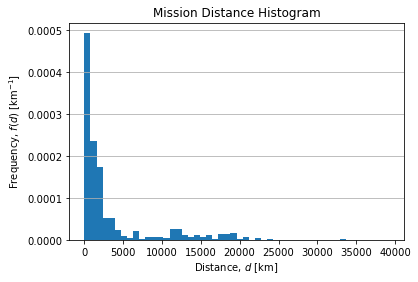

In [12]:
axe = missions['distance'].plot(kind='hist', bins=50, density=1)
axe.set_title("Mission Distance Histogram")
axe.set_xlabel(r"Distance, $d$ $[\mathrm{km}]$")
axe.set_ylabel(r"Frequency, $f(d)$ $[\mathrm{km^{-1}}]$")
axe.grid(axis='y')

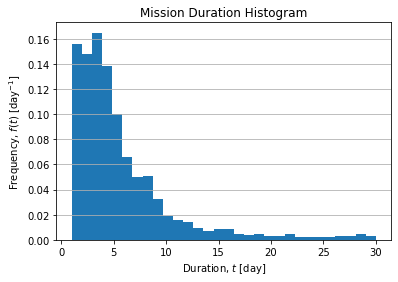

In [13]:
axe = missions['elapsed'].plot(kind='hist', bins=30, density=1)
axe.set_title("Mission Duration Histogram")
axe.set_xlabel(r"Duration, $t$ $[\mathrm{day}]$")
axe.set_ylabel(r"Frequency, $f(t)$ $[\mathrm{day^{-1}}]$")
axe.grid(axis='y')

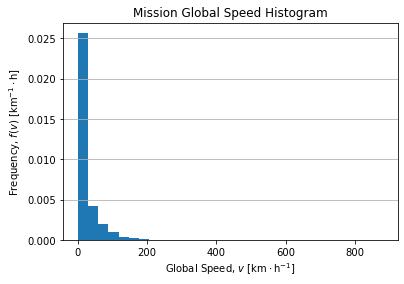

In [14]:
axe = missions['speed'].plot(kind='hist', bins=30, density=1)
axe.set_title("Mission Global Speed Histogram")
axe.set_xlabel(r"Global Speed, $v$ $[\mathrm{km\cdot h^{-1}}]$")
axe.set_ylabel(r"Frequency, $f(v)$ $[\mathrm{km^{-1}\cdot h}]$")
axe.grid(axis='y')

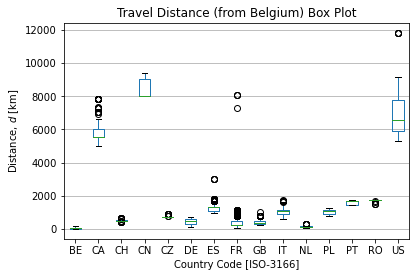

In [15]:
k = ['FR', 'GB', 'IT', 'DE', 'BE', 'ES', 'US', 'NL', 'CH', 'CA', 'PL', 'CZ', 'CN', 'PT', 'RO']
d = travels.loc[(travels['from_ISO2']=='BE')&travels['to_ISO2'].isin(k),:]
axe = d.boxplot(column='distance', by='to_ISO2')
axe.set_title("Travel Distance (from Belgium) Box Plot")
axe.set_xlabel(r"Country Code [ISO-3166]")
axe.set_ylabel(r"Distance, $d$ $[\mathrm{km}]$")
axe.grid(axis='x')
_ = axe.get_figure().suptitle('')

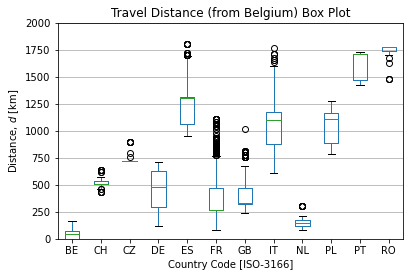

In [16]:
k = ['FR', 'GB', 'IT', 'DE', 'BE', 'ES', 'NL', 'CH', 'PL', 'CZ', 'PT', 'RO']
d = travels.loc[(travels['from_ISO2']=='BE')&travels['to_ISO2'].isin(k),:]
axe = d.boxplot(column='distance', by='to_ISO2')
axe.set_title("Travel Distance (from Belgium) Box Plot")
axe.set_xlabel(r"Country Code [ISO-3166]")
axe.set_ylabel(r"Distance, $d$ $[\mathrm{km}]$")
axe.grid(axis='x')
axe.set_ylim([0,2000])
_ = axe.get_figure().suptitle('')

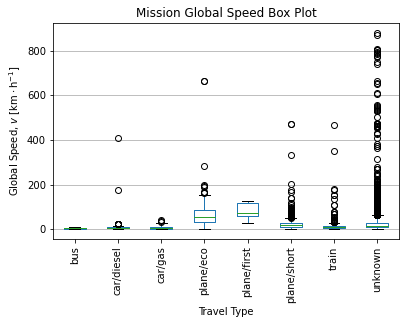

In [17]:
axe = missions.boxplot(column='speed', by='travel_type', rot=90)
axe.set_title("Mission Global Speed Box Plot")
axe.set_xlabel(r"Travel Type")
axe.set_ylabel(r"Global Speed, $v$ $[\mathrm{km\cdot h^{-1}}]$")
axe.grid(axis='x')
_ = axe.get_figure().suptitle('')

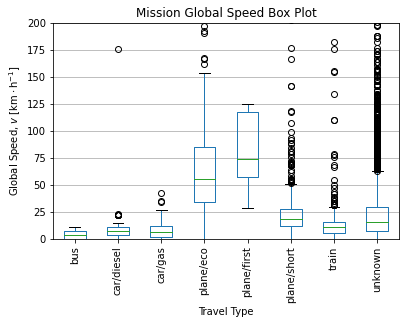

In [18]:
axe = missions.boxplot(column='speed', by='travel_type', rot=90)
axe.set_title("Mission Global Speed Box Plot")
axe.set_xlabel(r"Travel Type")
axe.set_ylabel(r"Global Speed, $v$ $[\mathrm{km\cdot h^{-1}}]$")
axe.grid(axis='x')
axe.set_ylim([0 ,200])
_ = axe.get_figure().suptitle('')

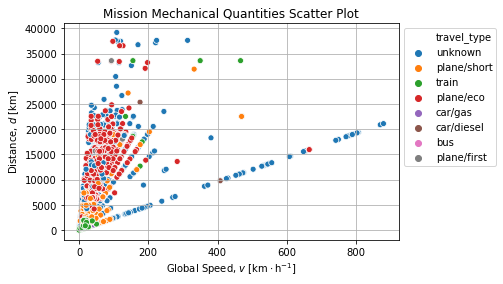

In [19]:
axe = sns.scatterplot(x='speed', y='distance', hue='travel_type', data=missions)
axe.set_title("Mission Mechanical Quantities Scatter Plot")
axe.set_xlabel(r"Global Speed, $v$ $[\mathrm{km\cdot h^{-1}}]$")
axe.set_ylabel(r"Distance, $d$ $[\mathrm{km}]$")
axe.legend(bbox_to_anchor=(1,1), loc='upper left')
axe.grid()

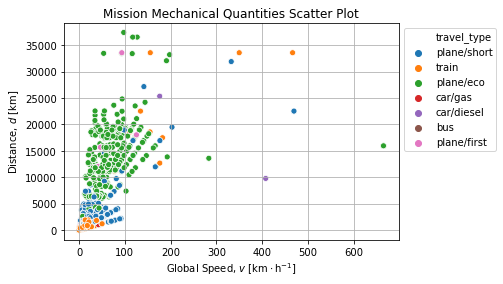

In [20]:
axe = sns.scatterplot(x='speed', y='distance', hue='travel_type',
                      data=missions.loc[~(missions['travel_type']=='unknown'),:])
axe.set_title("Mission Mechanical Quantities Scatter Plot")
axe.set_xlabel(r"Global Speed, $v$ $[\mathrm{km\cdot h^{-1}}]$")
axe.set_ylabel(r"Distance, $d$ $[\mathrm{km}]$")
axe.legend(bbox_to_anchor=(1,1), loc='upper left')
axe.grid()

### Dataset Rendering

In [21]:
y = missions['start'].dt.year

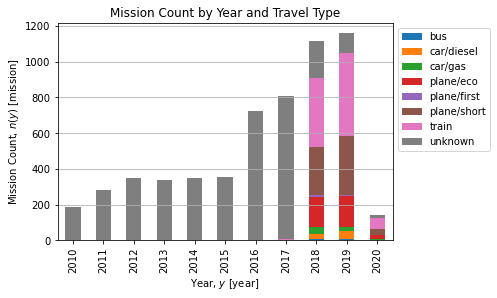

In [22]:
mc = missions.groupby([y, 'travel_type'])['mission_id'].count().unstack()
axe = mc.plot(kind='bar', stacked=True)
axe.set_title("Mission Count by Year and Travel Type")
axe.set_xlabel(r"Year, $y$ $[\mathrm{year}$]")
axe.set_ylabel(r"Mission Count, $n(y)$ $[\mathrm{mission}]$")
axe.legend(bbox_to_anchor=(1,1), loc='upper left')
axe.grid(axis='y')

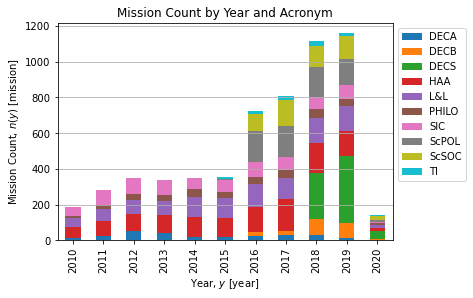

In [23]:
mc = missions.groupby([y, 'acronym'])['mission_id'].count().unstack()
axe = mc.plot(kind='bar', stacked=True)
axe.set_title("Mission Count by Year and Acronym")
axe.set_xlabel(r"Year, $y$ $[\mathrm{year}$]")
axe.set_ylabel(r"Mission Count, $n(y)$ $[\mathrm{mission}]$")
axe.legend(bbox_to_anchor=(1,1), loc='upper left')
axe.grid(axis='y')

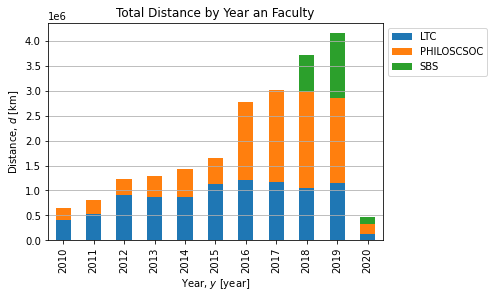

In [24]:
mc = missions.groupby([y, 'faculty'])['distance'].sum().unstack()
axe = mc.plot(kind='bar', stacked=True)
axe.set_title("Total Distance by Year an Faculty")
axe.set_xlabel(r"Year, $y$ $[\mathrm{year}$]")
axe.set_ylabel(r"Distance, $d$ $[\mathrm{km}]$")
axe.legend(bbox_to_anchor=(1,1), loc='upper left')
axe.grid(axis='y')

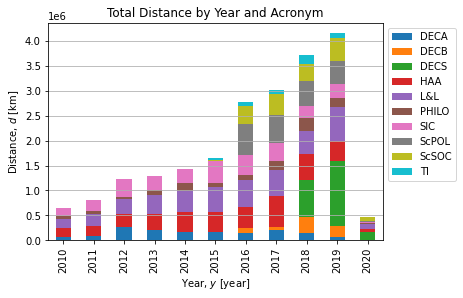

In [25]:
mc = missions.groupby([y, 'acronym'])['distance'].sum().unstack()
axe = mc.plot(kind='bar', stacked=True)
axe.set_title("Total Distance by Year and Acronym")
axe.set_xlabel(r"Year, $y$ $[\mathrm{year}$]")
axe.set_ylabel(r"Distance, $d$ $[\mathrm{km}]$")
axe.legend(bbox_to_anchor=(1,1), loc='upper left')
axe.grid(axis='y')

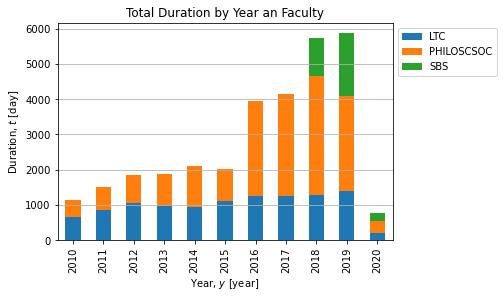

In [26]:
mc = missions.groupby([y, 'faculty'])['elapsed'].sum().unstack()
axe = mc.plot(kind='bar', stacked=True)
axe.set_title("Total Duration by Year an Faculty")
axe.set_xlabel(r"Year, $y$ $[\mathrm{year}$]")
axe.set_ylabel(r"Duration, $t$ $[\mathrm{day}]$")
axe.legend(bbox_to_anchor=(1,1), loc='upper left')
axe.grid(axis='y')

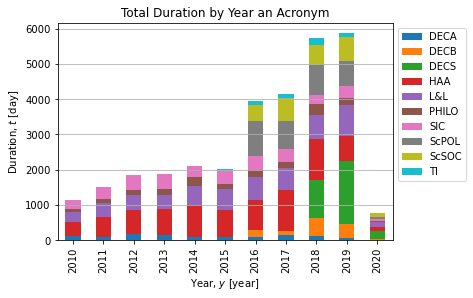

In [27]:
mc = missions.groupby([y, 'acronym'])['elapsed'].sum().unstack()
axe = mc.plot(kind='bar', stacked=True)
axe.set_title("Total Duration by Year an Acronym")
axe.set_xlabel(r"Year, $y$ $[\mathrm{year}$]")
axe.set_ylabel(r"Duration, $t$ $[\mathrm{day}]$")
axe.legend(bbox_to_anchor=(1,1), loc='upper left')
axe.grid(axis='y')

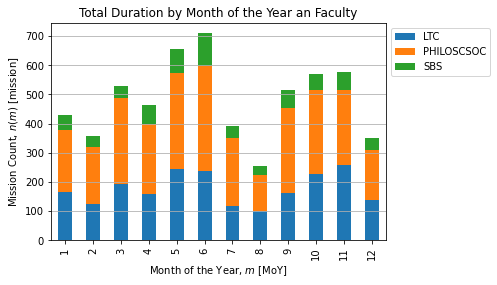

In [28]:
m = missions['start'].dt.month
axe = missions.groupby([m, 'faculty'])['mission_id'].count().unstack().plot(kind='bar', stacked=True)
axe.set_title("Total Duration by Month of the Year an Faculty")
axe.set_xlabel(r"Month of the Year, $m$ $[\mathrm{MoY}$]")
axe.set_ylabel(r"Mission Count, $n(m)$ $[\mathrm{mission}]$")
axe.legend(bbox_to_anchor=(1,1), loc='upper left')
axe.grid(axis='y')

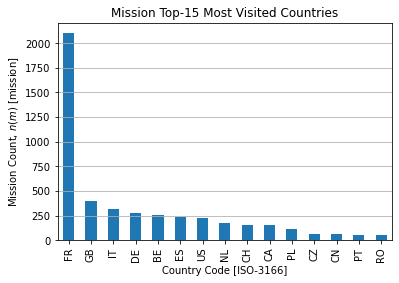

In [29]:
topc = missions.groupby("to_ISO2-1")["mission_id"].count().sort_values(ascending=False)
axe = topc[:15].plot(kind='bar')
axe.set_title("Mission Top-15 Most Visited Countries")
axe.set_xlabel(r"Country Code [ISO-3166]")
axe.set_ylabel(r"Mission Count, $n(m)$ $[\mathrm{mission}]$")
axe.grid(axis='y')

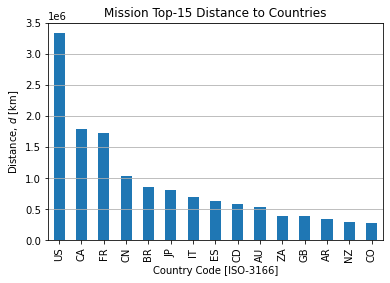

In [30]:
topd = missions.groupby("to_ISO2-1")["distance"].sum().sort_values(ascending=False)
axe = topd[:15].plot(kind='bar')
axe.set_title("Mission Top-15 Distance to Countries")
axe.set_xlabel(r"Country Code [ISO-3166]")
axe.set_ylabel(r"Distance, $d$ $[\mathrm{km}]$")
axe.grid(axis='y')

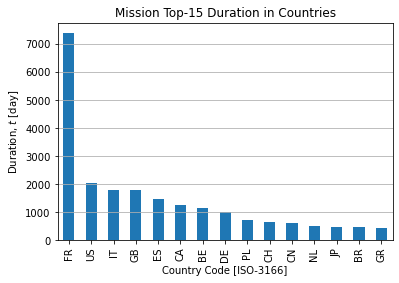

In [31]:
topt = missions.groupby("to_ISO2-1")["elapsed"].sum().sort_values(ascending=False)
axe = topt[:15].plot(kind='bar')
axe.set_title("Mission Top-15 Duration in Countries")
axe.set_xlabel(r"Country Code [ISO-3166]")
axe.set_ylabel(r"Duration, $t$ $[\mathrm{day}]$")
axe.grid(axis='y')

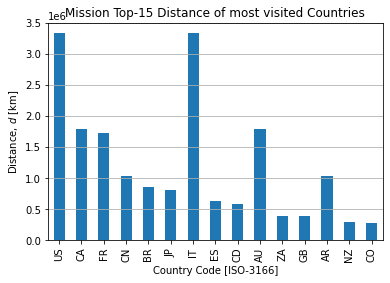

In [32]:
axe = topd[topc.index[:15]].plot(kind='bar')
axe = topd[:15].plot(kind='bar')
axe.set_title("Mission Top-15 Distance of most visited Countries")
axe.set_xlabel(r"Country Code [ISO-3166]")
axe.set_ylabel(r"Distance, $d$ $[\mathrm{km}]$")
axe.grid(axis='y')

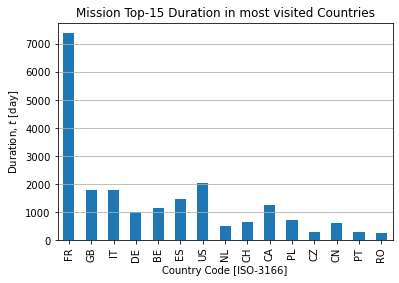

In [33]:
axe = topt[topc.index[:15]].plot(kind='bar')
axe.set_title("Mission Top-15 Duration in most visited Countries")
axe.set_xlabel(r"Country Code [ISO-3166]")
axe.set_ylabel(r"Duration, $t$ $[\mathrm{day}]$")
axe.grid(axis='y')

### Corrected Data

In [34]:
mai = pd.read_excel('data/missions_ai.xlsx')
mai = mai.loc[mai['elapsed']<31,:]
mai = mai.loc[mai['speed']<900,:]
mai = mai.loc[(mai['start']>='2010-01-01')&(mai['stop']<='2021-01-01'),:]
mai.sample(5)
mai.shape

(5801, 21)

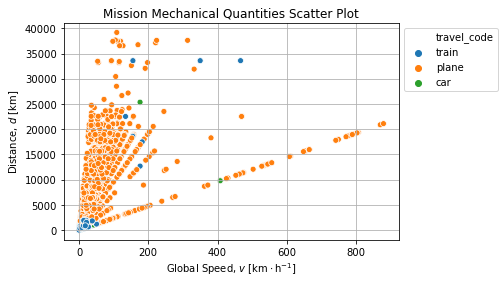

In [35]:
axe = sns.scatterplot(x='speed', y='distance', hue='travel_code', data=mai)
axe.set_title("Mission Mechanical Quantities Scatter Plot")
axe.set_xlabel(r"Global Speed, $v$ $[\mathrm{km\cdot h^{-1}}]$")
axe.set_ylabel(r"Distance, $d$ $[\mathrm{km}]$")
axe.legend(bbox_to_anchor=(1,1), loc='upper left')
axe.grid()

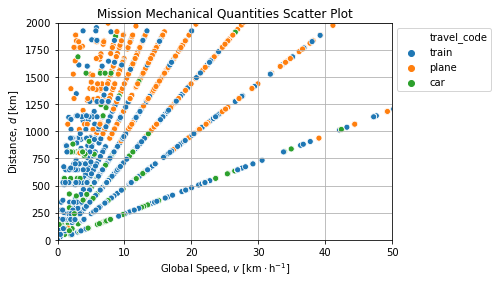

In [36]:
axe = sns.scatterplot(x='speed', y='distance', hue='travel_code', data=mai)
axe.set_title("Mission Mechanical Quantities Scatter Plot")
axe.set_xlabel(r"Global Speed, $v$ $[\mathrm{km\cdot h^{-1}}]$")
axe.set_ylabel(r"Distance, $d$ $[\mathrm{km}]$")
axe.legend(bbox_to_anchor=(1,1), loc='upper left')
axe.set_xlim([0, 50])
axe.set_ylim([0, 2000])
axe.grid()

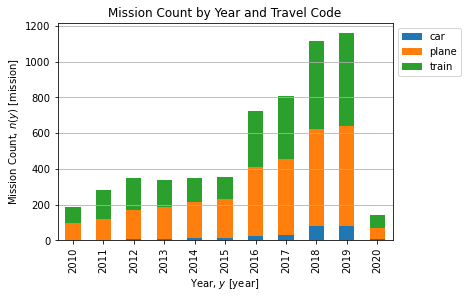

In [37]:
mc = mai.groupby([mai.start.dt.year, 'travel_code'])['mission_id'].count().unstack()
axe = mc.plot(kind='bar', stacked=True)
axe.set_title("Mission Count by Year and Travel Code")
axe.set_xlabel(r"Year, $y$ $[\mathrm{year}$]")
axe.set_ylabel(r"Mission Count, $n(y)$ $[\mathrm{mission}]$")
axe.legend(bbox_to_anchor=(1,1), loc='upper left')
axe.grid(axis='y')

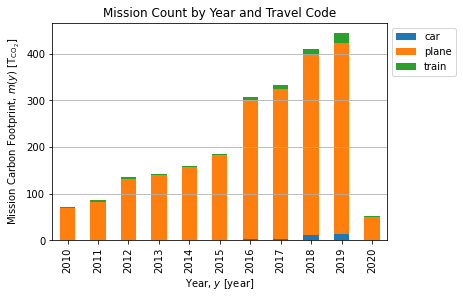

In [38]:
mc = mai.groupby([mai.start.dt.year, 'travel_code'])['CO2_equiv'].sum().unstack()/1e3
axe = mc.plot(kind='bar', stacked=True)
axe.set_title("Mission Count by Year and Travel Code")
axe.set_xlabel(r"Year, $y$ $[\mathrm{year}$]")
axe.set_ylabel(r"Mission Carbon Footprint, $m(y)$ $[\mathrm{T_{CO_2}}]$")
axe.legend(bbox_to_anchor=(1,1), loc='upper left')
axe.grid(axis='y')

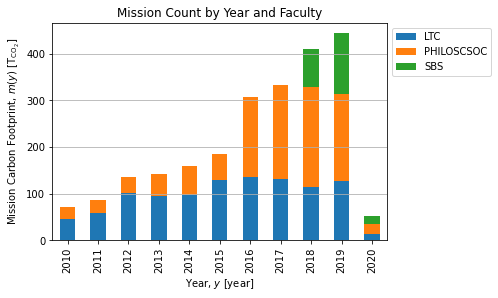

In [39]:
mc = mai.groupby([mai.start.dt.year, 'faculty'])['CO2_equiv'].sum().unstack()/1e3
axe = mc.plot(kind='bar', stacked=True)
axe.set_title("Mission Count by Year and Faculty")
axe.set_xlabel(r"Year, $y$ $[\mathrm{year}$]")
axe.set_ylabel(r"Mission Carbon Footprint, $m(y)$ $[\mathrm{T_{CO_2}}]$")
axe.legend(bbox_to_anchor=(1,1), loc='upper left')
axe.grid(axis='y')

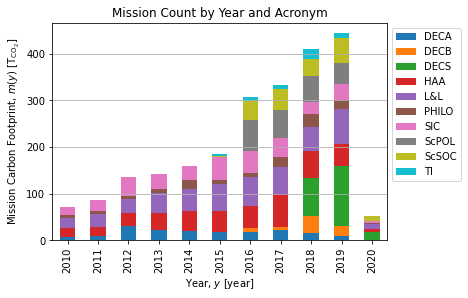

In [40]:
mc = mai.groupby([mai.start.dt.year, 'acronym'])['CO2_equiv'].sum().unstack()/1e3
axe = mc.plot(kind='bar', stacked=True)
axe.set_title("Mission Count by Year and Acronym")
axe.set_xlabel(r"Year, $y$ $[\mathrm{year}$]")
axe.set_ylabel(r"Mission Carbon Footprint, $m(y)$ $[\mathrm{T_{CO_2}}]$")
axe.legend(bbox_to_anchor=(1,1), loc='upper left')
axe.grid(axis='y')